In [1]:
import numpy as np
from numpy.random import uniform

"""initial particle distribution(uniform or Gaussian around init GPS)"""
def create_uniform_particles(x_range, y_range, hdg_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(hdg_range[0], hdg_range[1], size=N)
    particles[:, 2] %= 2 * np.pi
    return particles

def create_gaussian_particles(mean, std, N):
    particles = np.empty((N, 3))
    particles[:, 0] = mean[0] + (randn(N) * std[0])
    particles[:, 1] = mean[1] + (randn(N) * std[1])
    particles[:, 2] = mean[2] + (randn(N) * std[2])
    particles[:, 2] %= 2 * np.pi
    return particles

In [2]:
from scipy.stats import multivariate_normal

def predict(particles, u, std, dt=1.):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # update heading
    particles[:, 2] += u[0] + (randn(N) * std[0])
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = (u[1] * dt) + (randn(N) * std[1])
    particles[:, 0] += np.cos(particles[:, 2]) * dist
    particles[:, 1] += np.sin(particles[:, 2]) * dist
    
def update(particles, weights, z, R, landmarks):
    """weighting by iid mulvivariate Gaussian density
    with covs 0, is product of prob. of each dimensional variable"""
    for i, landmark in enumerate(landmarks):
        distance = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)
        weights *= scipy.stats.norm(distance, R).pdf(z[i])

    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize

def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""
    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var



In [3]:
def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, random(N))

    # resample according to indexes
    particles[:] = particles[indexes]
    weights.fill(1.0 / N)
    
def systematic_resample(weights):
    N = len(weights)

    # make N subdivisions, choose positions with a consistent random offset
    positions = (np.arange(N) + random()) / N
    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

def neff(weights):
    return 1. / np.sum(np.square(weights))

def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill (1.0 / len(weights))

In [6]:
# from filterpy.monte_carlo import systematic_resample
import matplotlib.pyplot as plt
from numpy.linalg import norm
from numpy.random import randn
from numpy.random import *
import scipy.stats

def run_pf21(N, iters=18, sensor_std_err=.1, 
            do_plot=True, plot_particles=False,
            xlim=(0, 20), ylim=(0, 20),
            initial_x=None):
    
    landmarks = np.array([[-1, 2], [5, 10], [12,14], [18,21]])
    NL = len(landmarks)
    plt.figure()
   
    # create particles and weights
    if initial_x is not None:
        particles = create_gaussian_particles(mean=initial_x, std=(5, 5, np.pi/4), N=N)
    else:
        particles = create_uniform_particles((0,20), (0,20), (0, 6.28), N)
    weights = np.ones(N) / N

    if plot_particles:
        alpha = .20
        if N > 5000:
            alpha *= np.sqrt(5000)/np.sqrt(N)           
        #plt.scatter(particles[:, 0], particles[:, 1], color='k', marker=',', s=1)
    
    xs,ps,errors = [],[],[]
    robot_pos = np.array([1., 1.])

    for x in range(iters):
        
        #robot_pos += (1+log(1+x)*rand(), 1+log(1+x)*rand())
        #robot_pos += (2+rand(), 2+rand())
        #robot_pos += (1+rand(), 1+rand())
        #robot_pos += (1, 1)
        
        ps.append(robot_pos)

        # distance from robot to each landmark
        zs = (norm(landmarks - robot_pos, axis=1) + (randn(NL) * sensor_std_err))

        # move diagonally forward to (x+1, x+1): u=(hd,vel)
        # state model f(x_t-1, u_t)
        #predict(particles, u=(0.00, 1.414), std=(.2, .05))
        predict(particles, u=(0.00, 1.414), std=(.4, .1))
        
        # incorporate measurements
        # measure model p(y_t | x_t')
        update(particles, weights, z=zs, R=sensor_std_err, landmarks=landmarks)

        # resample if too few effective particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)
        
        # weighted avg is est.
        mu, var = estimate(particles, weights)
        xs.append(mu)
        
        errors.append(np.linalg.norm(robot_pos-mu))
        print("params:", "errors:",np.linalg.norm(robot_pos-mu))

        if plot_particles:
            plt.scatter(particles[:, 0], particles[:, 1],alpha=alpha, color='g', s=20)
            
        p1 = plt.scatter(robot_pos[0], robot_pos[1], marker='+',color='k', s=180, lw=3)
        p2 = plt.scatter(mu[0], mu[1], marker='s', color='r', s = 10)
        
    xs = np.array(xs)
    #plt.plot(xs[:, 0], xs[:, 1])
    plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)
    print("Sum of Error Norm: \n\t {}".format(np.sum(errors)))
    plt.show()

params: errors: 0.1346172102037201
params: errors: 0.9653838439476455
params: errors: 2.698305647419485
params: errors: 4.1944782397252816
params: errors: 5.165732040208369
params: errors: 6.2233316495526925
params: errors: 6.73113491443385
params: errors: 5.452262710711141
params: errors: 4.370805677733085
params: errors: 3.5773244622668865
params: errors: 1.6459276060672832
params: errors: 0.07119052789597514
params: errors: 0.9291303301279353
params: errors: 1.91329989008271
params: errors: 2.7759661622555125
params: errors: 1.9791654890164516
params: errors: 0.4011620306880745
params: errors: 0.689279688757803
final position error, variance:
	 [-17.48224334 -16.50750853] [0.00619416 0.00755304]
Sum of Error Norm: 
	 49.918498121093904


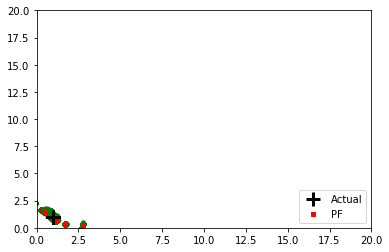

In [7]:
from numpy.random import seed
seed(2) 
run_pf21(N=5000, plot_particles=True, initial_x=(1,1, np.pi/4))

In [8]:
"""initial particle distribution(uniform or Gaussian around init GPS)"""
def create_uniform_particles(x_range, y_range, hdg_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(hdg_range[0], hdg_range[1], size=N)
    particles[:, 2] %= 2 * np.pi
    return particles

def create_gaussian_particles(mean, std, N):
    particles = np.empty((N, 3))
    particles[:, 0] = mean[0] + (randn(N) * std[0])
    particles[:, 1] = mean[1] + (randn(N) * std[1])
    particles[:, 2] = mean[2] + (randn(N) * std[2])
    particles[:, 2] %= 2 * np.pi
    return particles

def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, random(N))

    # resample according to indexes
    particles[:] = particles[indexes]
    weights.fill(1.0 / N)
    
def systematic_resample(weights):
    N = len(weights)

    # make N subdivisions, choose positions with a consistent random offset
    positions = (np.arange(N) + random()) / N
    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

def neff(weights):
    return 1. / np.sum(np.square(weights))

def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill (1.0 / len(weights))

In [9]:
from scipy.stats import multivariate_normal

def predict(particles, u, std, dt=1.):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # update heading
    particles[:, 2] += u[0] + (randn(N) * std[0])
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = (u[1] * dt) + (randn(N) * std[1])
    particles[:, 0] += np.cos(particles[:, 2]) * dist
    particles[:, 1] += np.sin(particles[:, 2]) * dist
    
def update(particles, weights, z, R, landmarks):
    """weighting by iid mulvivariate Gaussian density
    with covs 0, is product of prob. of each dimensional variable"""
    N = len(particles)
    
    for i, landmark in enumerate(landmarks):
        distance = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)
        weights *= scipy.stats.norm(distance, R).pdf(z[i])
        
    weights += 1.e-300
    tot_weights = sum(weights)
    weights /= sum(weights) # normalize
        
    return weights

def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""
    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

def predict_with_acc_try(acc,particles, u, std, dt=1.):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # update heading
    particles[:, 2] += (u[0] + acc[:,0]*(dt**2)/2 + (randn(N) * std[0]))
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = acc[:,1]*(dt**2)/2 + (randn(N) * std[0])
    particles[:, 0] += (np.cos(particles[:, 2]) * (u[1] * dt) + np.cos(particles[:, 2]) * dist)
    particles[:, 1] += (np.sin(particles[:, 2]) * (u[1] * dt) + np.sin(particles[:, 2]) * dist)

def predict_with_acc_mu(acc,particles, u, std, dt=1.):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # update heading
    particles[:, 2] += (u[0] + acc[0]*(dt**2)/2 + (randn(N) * std[0]))
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = acc[1]*(dt**2)/2 + (randn(N) * std[0])
    particles[:, 0] += (np.cos(particles[:, 2]) * (u[1] * dt) + np.cos(particles[:, 2]) * dist)
    particles[:, 1] += (np.sin(particles[:, 2]) * (u[1] * dt) + np.sin(particles[:, 2]) * dist)


def fobj(a, solution, particles, u, std, z, R, landmarks, dt=1.):
    N = len(particles)
    
    weights = np.ones(N) / N
    predict_with_acc_try(a, particles, u=(0.00, 1.414), std=(.2, .05))
    weights = update(particles, weights, z, R, landmarks)

    #return -1.*np.square(solution - weights)
    return np.square(solution - weights)

def estimate_a(a):
    """returns mean and variance of the weighted particles"""
    mean = np.average(a, axis=0)
    var  = np.average((a - mean)**2)
    return mean, var

In [10]:
# from filterpy.monte_carlo import systematic_resample
import matplotlib.pyplot as plt
import numpy as np
from math import *
from numpy.linalg import norm
from numpy.random import randn
from numpy.random import *
import scipy.stats

def run_pf300(N, iters=18, sensor_std_err=.1, 
            do_plot=True, plot_particles=False,
            xlim=(0, 20), ylim=(0, 20),
            initial_x=None):
    
    landmarks = np.array([[-1, 2], [5, 10], [12,14], [18,21]])
    NL = len(landmarks)
    plt.figure()
   
    if initial_x is not None:
        particles = create_gaussian_particles(mean=initial_x, std=(5, 5, np.pi/4), N=N)
    else:
        particles = create_uniform_particles((0,20), (0,20), (0, 6.28), N)
    weights = np.ones(N) / N

    if plot_particles:
        alpha = .20
        if N > 5000:
            alpha *= np.sqrt(5000)/np.sqrt(N)           
    
    xs, ps, errors = [], [], []
    robot_pos = np.array([1., 1.])
    
    #for evolutionary filters
    npop = len(particles)
    a = [0.0, np.random.randn()] # angular acc. = 0.0, linear acc =randn()

    sigma= 0.1
    lr= 0.01

    for x in range(iters):

        # distance from robot to each landmark
        #robot_pos += (log(1+x*0.8), log(1+x*0.8))
        #robot_pos += (1+randn(), 1+randn())
        #robot_pos += (1+rand(), 1+rand())
        #robot_pos += (1, 1)
        ps.append(robot_pos)
        
        # distance from robot to each landmark
        zs = (norm(landmarks - robot_pos, axis=1) + (randn(NL) * sensor_std_err))
        predict_with_acc_mu(a, particles, u=(0.00, 1.414), std=(.4, .1))
        weights = update(particles, weights, z=zs, R=sensor_std_err, landmarks=landmarks)
        
        # resample if too few effective particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)

        mu, var = estimate(particles, weights)
        xs.append(mu)
        
        errors.append(np.linalg.norm(robot_pos-mu))
        print("params:",a, "errors:",np.linalg.norm(robot_pos-mu))

        if plot_particles:
            plt.scatter(particles[:, 0], particles[:, 1],alpha=alpha, color='g', s=20)
            
        p1 = plt.scatter(robot_pos[0], robot_pos[1], marker='+',color='k', s=180, lw=3)
        p2 = plt.scatter(mu[0], mu[1], marker='s', color='r', s = 10)
        
    xs = np.array(xs)
    plt.plot(xs[:, 0], xs[:, 1])
    plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)
    print("Sum of Error Norm: \n\t {}".format(np.sum(errors)))
    plt.show()

params: [0.0, 0.22864179504556809] errors: 0.04380388081618533
params: [0.0, 0.22864179504556809] errors: 0.10347719151450573
params: [0.0, 0.22864179504556809] errors: 0.10039764252123728
params: [0.0, 0.22864179504556809] errors: 0.09549565030724462
params: [0.0, 0.22864179504556809] errors: 0.13256361769502892
params: [0.0, 0.22864179504556809] errors: 0.23478874156838778
params: [0.0, 0.22864179504556809] errors: 0.36324910026855
params: [0.0, 0.22864179504556809] errors: 0.49639213699133555
params: [0.0, 0.22864179504556809] errors: 0.492615900045905
params: [0.0, 0.22864179504556809] errors: 0.45517306225123094
params: [0.0, 0.22864179504556809] errors: 0.5351196975810316
params: [0.0, 0.22864179504556809] errors: 0.5601254424830162
params: [0.0, 0.22864179504556809] errors: 0.498260977254375
params: [0.0, 0.22864179504556809] errors: 0.45685492126766564
params: [0.0, 0.22864179504556809] errors: 0.4505983385134203
params: [0.0, 0.22864179504556809] errors: 0.4351723873237914
par

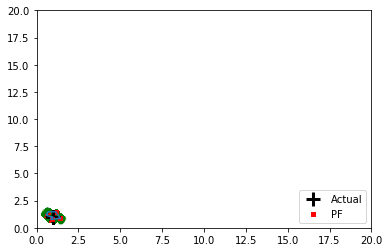

In [11]:
from numpy.random import seed
seed(2) 

run_pf300(N=5000, plot_particles=True, initial_x=(1,1, np.pi/4))

# Adapting parameters

In [12]:
# from filterpy.monte_carlo import systematic_resample
import matplotlib.pyplot as plt
import numpy as np
from math import *
from numpy.linalg import norm
from numpy.random import randn
from numpy.random import *
import scipy.stats

def run_pf301(N, iters=18, sensor_std_err=.1, 
            do_plot=True, plot_particles=False,
            xlim=(0, 20), ylim=(0, 20),
            initial_x=None):
    
    landmarks = np.array([[-1, 2], [5, 10], [12,14], [18,21]])
    NL = len(landmarks)
    plt.figure()
   
    if initial_x is not None:
        particles = create_gaussian_particles(mean=initial_x, std=(5, 5, np.pi/4), N=N)
    else:
        particles = create_uniform_particles((0,20), (0,20), (0, 6.28), N)
    weights = np.ones(N) / N

    if plot_particles:
        alpha = .20
        if N > 5000:
            alpha *= np.sqrt(5000)/np.sqrt(N)           
    
    xs, ps, errors = [], [], []
    robot_pos = np.array([1., 1.])
    
    #for evolutionary filters
    npop = len(particles)
    a = [0.0, np.random.randn()] #angular acc.=0, linear acc., 
    
    sigma= 0.1
    lr= 0.01

    for x in range(iters):

        #robot_pos += (log(1+x), log(1+x))
        #robot_pos += (1+randn(), 1+randn())
        #robot_pos += (1+rand(), 1+rand())
        #robot_pos += (1, 1)
        ps.append(robot_pos)
        
        # distance from robot to each landmark
        zs = (norm(landmarks - robot_pos, axis=1) + (randn(NL) * sensor_std_err))
        
        # for evolutionary filters optimization,
        # decide w s.t. likelihood to be maximized
        # for x_bar in range(3):
        S = np.random.randn(npop, 2) 
        R = np.zeros(npop) 

        a_try = a + sigma*S # jitter w using gaussian of sigma 0.1
        #R = fobj(a_try, weights, particles.copy(), u=(0.00, 1.414), std=(.2, .5), 
        #            z=zs, R=sensor_std_err, landmarks=landmarks, dt=1.)
        R = fobj(a_try, weights, particles.copy(), u=(0.00, 1.414), std=(.4, .1), 
                    z=zs, R=sensor_std_err, landmarks=landmarks, dt=1.)


        # standardize the rewards to have a gaussian distribution
        A = (R - np.mean(R)) / np.std(R)
        # perform the parameter update. The matrix multiply below
        # is just an efficient way to sum up all the rows of the noise matrix N,
        # where each row N[j] is weighted by A[j]
        a = a + lr/(npop*sigma) * np.dot(S.T, A)
        #print(a, estimate_a(a))
        
        #predict_with_acc_mu(a, particles, u=(0.00, 1.414), std=(.2, .05))
        predict_with_acc_mu(a, particles, u=(0.00, 1.414), std=(.4, .1))
        weights = update(particles, weights, z=zs, R=sensor_std_err, landmarks=landmarks)
        
        # resample if too few effective particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)

        mu, var = estimate(particles, weights)
        xs.append(mu)
        
        errors.append(np.linalg.norm(robot_pos-mu))
        print("params:",a, "errors:",np.linalg.norm(robot_pos-mu))

        if plot_particles:
            plt.scatter(particles[:, 0], particles[:, 1],alpha=alpha, color='g', s=20)
            
        p1 = plt.scatter(robot_pos[0], robot_pos[1], marker='+',color='k', s=180, lw=3)
        p2 = plt.scatter(mu[0], mu[1], marker='s', color='r', s = 10)
        
    xs = np.array(xs)
    plt.plot(xs[:, 0], xs[:, 1])
    plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)
    print("Sum of Error Norm: \n\t {}".format(np.sum(errors)))
    plt.show()

params: [0.00025764 0.22790971] errors: 0.11107252117709186
params: [-0.00029021  0.22469276] errors: 0.24683664625208745
params: [-0.00049177  0.22289065] errors: 0.1748318068031164
params: [0.00095905 0.22189251] errors: 0.21931045128404533
params: [0.00098744 0.22011505] errors: 0.214798045574006
params: [-0.00037069  0.21719934] errors: 0.06884513177623645
params: [-0.00326118  0.21719008] errors: 0.21957624122647967
params: [-0.00416431  0.21583685] errors: 0.16260671466119933
params: [-0.0045092   0.21595555] errors: 0.27398070984561484
params: [-0.00495336  0.21372074] errors: 0.32977876707528564
params: [-0.00427549  0.21156582] errors: 0.49134560165703667
params: [-0.00515703  0.20763781] errors: 0.2810568857579628
params: [-0.00563729  0.20585433] errors: 0.15994822304762094
params: [-0.00400838  0.2038887 ] errors: 0.22630399466636472
params: [-0.00388397  0.20311352] errors: 0.14718275259047267
params: [-0.00317652  0.20219409] errors: 0.2642432941877796
params: [-0.0068585

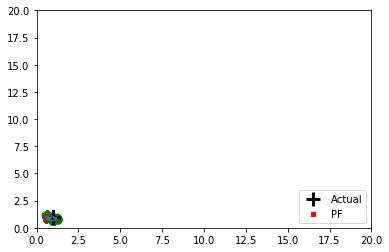

In [13]:
from numpy.random import seed
seed(2) 
#run_pf5(N=5000, plot_particles=True)
run_pf301(N=5000, plot_particles=True, initial_x=(1,1, np.pi/4))